**J. Behler and M. Parrinello, Generalized Neural-Network Representation of High-Dimensional Potential-Energy Surfaces, PRL 98, 146401 (2007)**

In [1]:
from math import exp, pow, sqrt, tanh, pi, cos, acos, ceil
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
import numpy as np
import random
import itertools
from pytorch_lightning import loggers as pl_loggers
from sklearn.model_selection import train_test_split
import math
import sys
torch.set_default_dtype(torch.float64)

![TOC.jpg](./TOC.jpg)

In [2]:
#Load data 
# Here We need coords in qm and mm; Energy and atom_type

Num_atom     = 14        # 14 atom in qm 
Num_atom_all = 6041      # all atom include 16 atom in qm area and  2009 H2O in mm area

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # set device

Energy = torch.from_numpy(np.array(np.load("energy.npy"), dtype="float64")) #[Num_config]
qm_coords = torch.from_numpy(np.array(np.load("qm_coord.npy"), dtype="float64"))#QM_coord [Num_config,Num_atom,3(xyz)]
mm_coords = torch.from_numpy(np.array(np.load("env_coord.npy"), dtype="float64")) #QM_coord [Num_config,Num_atom-Num_atom_all,3(xyz)]
atom_types = torch.from_numpy(np.array(np.load("element.npy"), dtype="float64")) #Atom_type [Num_atom_all] as "C=6,H=1,O=8"
elems = np.unique(atom_types).tolist()
atom_types = torch.from_numpy(np.array([elems.index(i) for i in atom_types[:Num_atom]])).to(device)
atom_types = atom_types.repeat(len(qm_coords), 1).long() # [Num_config,Num_atom_all]

Num_config  = len(Energy)

# Scheme to split dataset 

train_ratio = 0.8      # 95% data to train
validation_ratio = 0.2 #  5% data for validation

Num_train = int(Num_config * train_ratio) # Number of training set
Num_valid= Num_config-Num_train

# TIP3P water charge
charge_of_water = [-0.834, 0.417, 0.417] # 0,H,H
Charge_water = torch.Tensor(np.repeat(np.array(charge_of_water), int((Num_atom_all-Num_atom)/3)).reshape(3,-1).swapaxes(1,0).reshape(-1))


In [3]:
#Package parameters to class
class BP_param (object):
    def __init__(self):
        self.Num_atom = None
        self.Num_atom_all = None
        self.Num_conf = None
        self.Rca      = None
        self.Rcr      = None
        self.ShfR     = None
        self.EtaA     = None
        self.EtaR     = None
        self.Zeta     = None
        self.ShfZ     = None
        self.ShfA     = None
        self.Charge_water = None
        
    #def configuration(self, Num_atom, Num_atom_all, Num_config,Rcr, EtaR, ShfR, Rca, Zeta,  EtaA, charge_of_water,ShfZ=None,ShfA=None):
    def configuration(self, ParameterDict):
        '''specify'''
        if 'Num_atom' in  ParameterDict.keys(): self.Num_atom = Num_atom
        if 'Num_atom' in  ParameterDict.keys(): self.Num_atom_all = Num_atom_all
        if 'Num_atom' in  ParameterDict.keys(): self.Num_conf = Num_config
        if 'Rca'  in  ParameterDict.keys(): self.Rca      = Rca   #Rc in G2
        if 'Rcr'  in  ParameterDict.keys(): self.Rcr      = Rcr   #Rc in G3
        if 'ShfR' in  ParameterDict.keys(): self.ShfR     = torch.Tensor(ShfR)  #Rs in G2
        if 'EtaA' in  ParameterDict.keys(): self.EtaA     = torch.Tensor(EtaA)  #Eta  in G3
        if 'EtaR' in  ParameterDict.keys(): self.EtaR     = torch.Tensor(EtaR)  #Eta  in G2
        if 'Zeta' in  ParameterDict.keys(): self.Zeta     = torch.Tensor(Zeta) #Zeta/Xi in G3
        if 'ShfZ' in  ParameterDict.keys(): self.ShfZ     = torch.Tensor(ShfZ)  #Shift Z in ANI model
        if 'ShfA' in  ParameterDict.keys(): self.ShfA     = torch.Tensor(ShfA)  #Shift A in ANI model
        if 'Charge_water' in  ParameterDict.keys(): self.Charge_water = torch.Tensor(Charge_water)


In [4]:
# load hyperparameter
Rcr  = 6.0 #Rc in G2
Rca  = 6.0 #Rc in G3
ShfR = [element*0.5291772 for element in [2.0,4.0,6.0, 8.0, 10.0]]          #Rs   in G2
EtaA = [element/0.5291772**2 for element in [5.00, 0.40, 0.10, 0.03, 0.01]] #Eta  in G3
EtaR = [element/0.5291772**2 for element in [5.00,0.40, 0.10, 0.03, 0.01]]  #Eta  in G2
Zeta = [14.0]                                                                #Zeta/Xi in G3
EtaR, ShfR = np.array(np.meshgrid(EtaR, ShfR)).reshape(2, -1)
Zeta, EtaA= np.array(np.meshgrid(Zeta, EtaA)).reshape(2, -1)
EtaR = np.repeat([EtaR], 3, axis=0)
ShfR = np.repeat([ShfR], 3, axis=0)
Zeta = np.repeat([Zeta], 3, axis=0)
EtaA = np.repeat([EtaA], 3, axis=0)

List_param_key=['Num_atom', 'Num_atom_all', 'Num_config','Rcr', 'EtaR', 'ShfR', 'Rca', 'Zeta',  'EtaA', 'Charge_water']
List_param_value=[Num_atom, Num_atom_all, Num_config,Rcr, EtaR, ShfR, Rca, Zeta,  EtaA, Charge_water]
ParameterDict = dict(zip(List_param_key, List_param_value))

#List_param_key_ani_append=['ShfZ','ShfA'] #ADD ANI param
#List_param_value_ani_append=[ShfZ,Shfa]
#ParameterDict.update(dict(zip(List_param_key_ani_append, List_param_value_ani_append)))

param = BP_param()
param.configuration(ParameterDict)

In [5]:
# symmetric function
def self_qm_vector(coords: Tensor) -> Tensor:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    mask = ~torch.eye(num_channels, dtype=torch.bool, device=coords.device) # remove self-interaction
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    return rij #[Num_config,Num_atom,Num_atom-1,3(xyz)]

def qm_mm_vector(coords:Tensor,mm_coords:Tensor ) -> Tensor:
    rij_2 = coords[:, :, None] - mm_coords[:, None]
    return rij_2 #[Num_config,Num_atom,Num_atom_all-Num_atom,3(xyz)]


def symmetry_function_g2(rij: Tensor, Rcr: float, EtaR: Tensor, ShfR: Tensor) -> Tensor:
    dij = torch.norm(rij, dim=3)
    sij = dij/Rcr
    fij = (torch.cos(torch.where(sij>1,1,sij) * math.pi) + 1) * 0.5
    g2 = torch.sum(torch.exp(-EtaR.unsqueeze(dim=2) * (dij.unsqueeze(dim=-1) - ShfR.unsqueeze(dim=2))**2) * fij.unsqueeze(dim=-1), dim=2)
    
    return g2

def symmetry_function_g3(rij: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]
    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    d23 = torch.norm(r23, dim=3)
    
    #cut if dij>Rca
    s12 = d12/Rca
    s13 = d13/Rca
    s23 = d23/Rca
    f12 = (torch.cos(torch.where(s12>1,1,s12) * math.pi) + 1) * 0.5
    f13 = (torch.cos(torch.where(s13>1,1,s13)  * math.pi) + 1) * 0.5
    f23 = (torch.cos(torch.where(s23>1,1,s23)  * math.pi) + 1) * 0.5

    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)
    g3 = torch.sum(2**(1 - Zeta.unsqueeze(dim=2)) * ((1 + cosine.unsqueeze(dim=-1))**Zeta.unsqueeze(dim=2)) * torch.exp(-EtaA.unsqueeze(dim=2) * (d12**2 + d13**2 + d23**2).unsqueeze(dim=-1)) * (f12 * f13 * f23).unsqueeze(dim=-1), dim=2)

    return g3
def symmetry_function_gw(rij_env: Tensor,Chargewater:Tensor) -> Tensor:
    dij_env = torch.norm(rij_env, dim=3)
    gw=torch.sum(Charge_water/dij_env,dim=2).unsqueeze(dim=-1)
    return gw    


In [6]:
class Feature_BP_molecule(BP_param):
    def __init__(self):
        super().__init__()
        
    def Calculate_Feature(self,coords: Tensor, atom_types: Tensor,mm_coords:Tensor,Normalization: bool = True)-> Tensor:
        rij = self_qm_vector(coords)
        rij_env=qm_mm_vector(coords,mm_coords)
        print(rij.shape,rij_env.shape,'x')
        #print(ShfR.shape,'shfr')
        EtaR = self.EtaR[atom_types]
        ShfR = self.ShfR[atom_types]
        Zeta = self.Zeta[atom_types]
        EtaA = self.EtaA[atom_types]
        g2 = symmetry_function_g2(rij, self.Rcr, EtaR, ShfR)
        g3 = symmetry_function_g3(rij, self.Rca, Zeta, EtaA)
        gv = symmetry_function_gw(rij_env,self.Charge_water)
        result=torch.concat((g2,g3,gv), dim=2)
        
        if Normalization:       
            # normalization to [-1,1]
            fmax,_ = torch.max(result,0)
            fmax = fmax.unsqueeze(dim=0)
            fmin,_ = torch.min(result,0)
            fmin =fmin.unsqueeze(dim=0)
            result=2*(result-fmin)/(fmax-fmin+1.0e-32)-1 # Division is dangerous 
        
        return result
    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])+1 # g2 + g3 + gv

In [7]:
#Feature

Feature_BP =Feature_BP_molecule()
Feature_BP.configuration(ParameterDict)
Num_Feature=Feature_BP.output_length
descriptor =Feature_BP.Calculate_Feature(qm_coords, atom_types,mm_coords).reshape(-1,Num_atom * Num_Feature)
input_feature_train, input_feature_valid,energy_train, energy_valid = train_test_split(descriptor, Energy, test_size=1 - train_ratio)


torch.Size([1000, 14, 13, 3]) torch.Size([1000, 14, 6027, 3]) x


In [11]:
#pytorch tensordataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_train = input_feature_train.to(device)
input_valid = input_feature_valid.to(device)
output_train = energy_train.to(device)
output_valid = energy_valid.to(device)

DLparams = {'batch_size': 120,
            'shuffle': True}
test_DLparams = {'batch_size': Num_valid,
                'shuffle': False}

dataset_train = TensorDataset(input_train, output_train)
dataset_valid = TensorDataset(input_valid, output_valid)

loader_train = DataLoader(dataset_train, **DLparams)
loader_valid = DataLoader(dataset_valid, **test_DLparams)

In [12]:
#training process
class PlNeuralNet(pl.LightningModule):
    def __init__(self, n_net=1, n0=3, n1=10, lr=1.e-2):
        super().__init__()
        subnets = []
        for i_net in range(n_net):
            subnet = nn.Sequential(
                nn.Linear(n0, n1),
                nn.Tanh(),
                nn.Linear(n1, 1)
            )
            subnets.append(subnet)
            
        self.model = nn.ModuleList(subnets)
        self.learning_rate = lr

    def forward(self, x):    
        b_size, n_atom = x.shape
        atomic_E = torch.zeros((b_size, n_atom//Num_Feature)).to(device)
        for i_atom in range(Num_atom):
            i_subnet = atom_types[0,i_atom]
            atomic_E[:,i_atom] = torch.flatten(self.model[i_subnet](x[:,Num_Feature*i_atom:Num_Feature*(i_atom+1)]))
        Eout  = atomic_E.sum(axis=1)
        return Eout


    def training_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        loss = lossfn(z_pred.squeeze(), z)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        lossval = lossfn(z_pred.squeeze(), z)
        self.log('valloss', lossval)
        return lossval
    
    def test_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        losstest = lossfn(z_pred.squeeze(), z)
        self.log('testloss', losstest)
        return losstest
    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.97),
                     'interval': 'epoch',
                     'frequency': 5,
                    }
        return [optimizer] #, [scheduler]

In [16]:
from pytorch_lightning.callbacks import ModelCheckpoint   
num_epochs = 300
checkpoint_callback = ModelCheckpoint(save_top_k = -1, save_last = False, every_n_epochs = 10)#100 epochs to save once 
csv_logger = pl_loggers.CSVLogger('logs_csv/', flush_logs_every_n_steps = 10)
trainer = pl.Trainer(max_epochs = num_epochs, log_every_n_steps = 10, logger = csv_logger, callbacks = [checkpoint_callback], accelerator = "auto", devices = "auto")

Num_element=3
n1 = Num_Feature // 2
n_net = Num_element
learning_rate = 3.e-2
print('n1=',n1)
model = PlNeuralNet(n_net, Num_Feature, n1, learning_rate)

trainer.fit(model, loader_train, loader_valid)
trainer.validate(dataloaders = loader_valid, ckpt_path = 'best')


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | ModuleList | 1.5 K 
-------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


n1= 15


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\wjn\AppData\Local

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
Restoring states from the checkpoint path at logs_csv/lightning_logs\version_1\checkpoints\epoch=299-step=2100.ckpt
Loaded model weights from checkpoint at logs_csv/lightning_logs\version_1\checkpoints\epoch=299-step=2100.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         valloss            0.8071721178610304
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valloss': 0.8071721178610304}]

In [19]:
#print param

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    #print(param_tensor, "\t", model.state_dict()[param_tensor])

model.0.0.weight 	 torch.Size([15, 31])
model.0.0.bias 	 torch.Size([15])
model.0.2.weight 	 torch.Size([1, 15])
model.0.2.bias 	 torch.Size([1])
model.1.0.weight 	 torch.Size([15, 31])
model.1.0.bias 	 torch.Size([15])
model.1.2.weight 	 torch.Size([1, 15])
model.1.2.bias 	 torch.Size([1])
model.2.0.weight 	 torch.Size([15, 31])
model.2.0.bias 	 torch.Size([15])
model.2.2.weight 	 torch.Size([1, 15])
model.2.2.bias 	 torch.Size([1])


Text(0, 0.5, 'Errors')

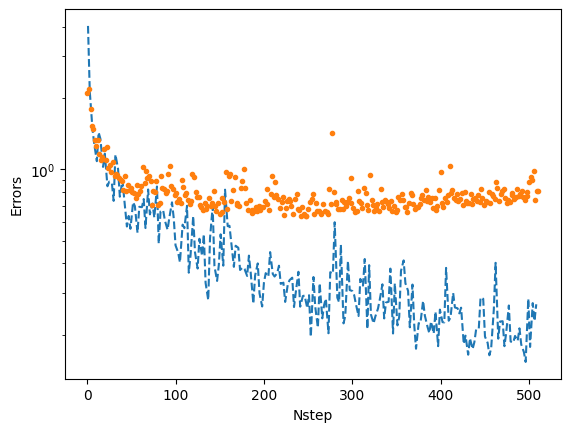

In [20]:
#plot 
import pandas as pd

loss_pack = pd.read_csv("logs_csv/lightning_logs/version_1/metrics.csv")
loss_valid = loss_pack.valloss.dropna()
loss_train = loss_pack.train_loss.dropna()


fig, ax = plt.subplots()
ax.semilogy(loss_train,'--',loss_valid,'.')
ax.set_xlabel("Nstep")
ax.set_ylabel("Errors")
# Show the predicted surface, and compare to the reference one

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_net=1, n0=3, n1=10):  #n1 is the number of neurons for the first layer
        super().__init__()
        subnets = []
        for i_net in range(n_net):
            subnet = nn.Sequential(
                nn.Linear(n0, n1),
                nn.Tanh(),
#                nn.Linear(n1, n1),
#                nn.Tanh(),
                nn.Linear(n1, 1)
            )
            subnets.append(subnet)
        self.model = nn.ModuleList(subnets)

    def forward(self, x):
        b_size, n_atom = x.shape
        atomic_E = torch.zeros((b_size, n_atom//Num_Feature)).to(device)
        for i_atom in range(Num_atom):
            i_subnet = atom_types[0,i_atom]
            atomic_E[:,i_atom] = torch.flatten(self.model[i_subnet](x[:,Num_Feature*i_atom:Num_Feature*(i_atom+1)]))
        Eout  = torch.sum(atomic_E, axis = 1)
        return Eout

def train_loop(dataloader, model, lossfn, optimizer, i_epoch):
    size = len(dataloader.dataset)
    for batch, (input_feature, target) in enumerate(dataloader):
        pred = model(input_feature)   # call model.forward()
        loss = lossfn(pred.squeeze(), target)
    
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch+1 == ceil(len(dataloader.dataset)/DLparams['batch_size']) and i_epoch % 10 == 0:
            loss, current = loss.item(), batch * len(input_feature)
            print(f"epoch: {i_epoch:>4d} loss: {loss:>7.3f}  [{current:>5d}/{size:>5d}]")

In [26]:
# Training of Machine Learning Model
learning_rate = 3e-2
num_epochs = 100
n_net = Num_element
n1 = Num_Feature // 2
model = NeuralNetwork(n_net, Num_Feature, n1).to(device)
lossfn = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1.E-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.97)

for i_epoch in range(num_epochs):
    train_loop(loader_train, model, lossfn, optimizer, i_epoch)
    scheduler.step()
    
print("Done with Training!")

epoch:    0 loss:   4.591  [  480/  800]
epoch:   10 loss:   1.380  [  480/  800]
epoch:   20 loss:   0.769  [  480/  800]
epoch:   30 loss:   0.702  [  480/  800]
epoch:   40 loss:   0.583  [  480/  800]
epoch:   50 loss:   0.500  [  480/  800]
epoch:   60 loss:   0.628  [  480/  800]
epoch:   70 loss:   0.634  [  480/  800]
epoch:   80 loss:   0.442  [  480/  800]
epoch:   90 loss:   0.461  [  480/  800]
Done with Training!
